In [1]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Song Popularity - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebookk


__________________________________
# 2 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [2]:
# load dataset
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/dataset_song_popularity.csv')
popularity_labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_popularity_labels.csv')
echo_popul.set_index('track_id', inplace=True)
popularity_labels.set_index('track_id', inplace=True)
echo_popul = echo_popul.merge(popularity_labels, on='track_id')
echo_popul['bit_rate'] = echo_popul['bit_rate']//1000
echo_popul.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,listens,bit_rate,song_popularity
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,1293,256,not popular
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,514,256,not popular
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,1151,256,not popular
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,50135,192,popular
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,943,256,not popular


In [3]:
pd.concat([echo_popul.song_popularity.value_counts(),
                round(echo_popul.song_popularity.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
not popular,12399,94.44
popular,730,5.56


In [4]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['song_popularity'] = le.fit_transform(echo_popul['song_popularity'])
print('legend:\n0: not popular\n1: popular')
echo_popul['song_popularity'].value_counts()

legend:
0: not popular
1: popular


0    12399
1      730
Name: song_popularity, dtype: int64

In [5]:
labels = echo_popul[['song_popularity']]
labels.reset_index(drop=True, inplace=True)
labels = labels['song_popularity']

In [6]:
echo_popul.drop('song_popularity', axis=1, inplace=True)

[]

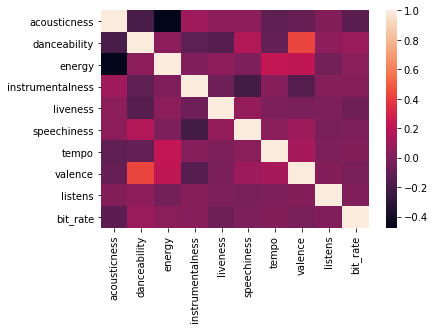

In [7]:
# features correlation
corr = echo_popul.corr()
sns.heatmap(corr)
plt.plot()

In [8]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_popul)

## b) Compute PCA and plot distribution in 2D

In [9]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(8,random_state=42)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [10]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=42, stratify=labels)

In [11]:
# development set shape
X.shape, y.shape

((9190, 8), (9190,))

In [12]:
# internal test shape
X_test.shape, y_test.shape

((3939, 8), (3939,))

In [13]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
0,8679,94.44
1,511,5.56


In [14]:
# function for plotting data in 2D with PCA
def pca_2D(data, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = data[:,0]
    df['pca2'] = data[:,1]
    df['song_popularity'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='song_popularity',
        palette={'not popular':'darkblue','popular':'red'},
        data=df,
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

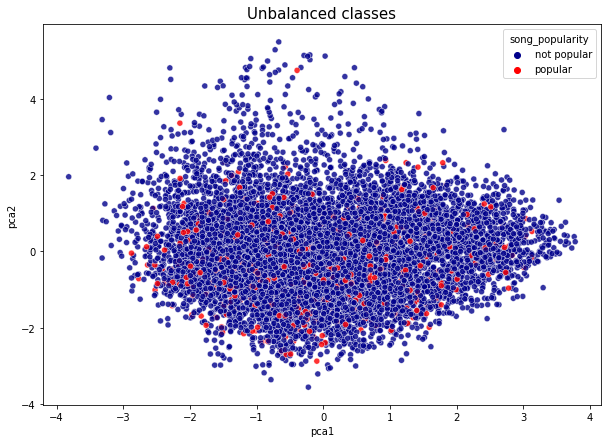

In [15]:
pca_2D(X, y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [16]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [17]:
print('Legend:\n0: not popular\n1: popular\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: not popular
1: popular
Class distribution after Random Undersampling:


0    511
1    511
Name: song_popularity, dtype: int64

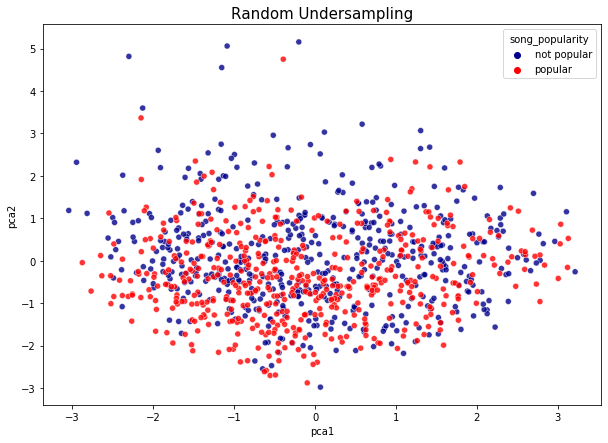

In [18]:
pca_2D(X_under,y_under,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

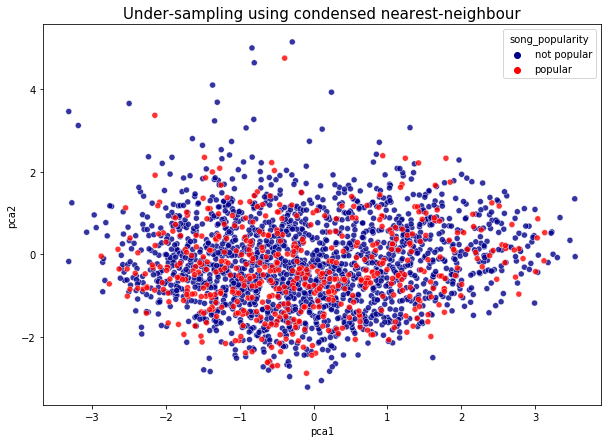

In [19]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

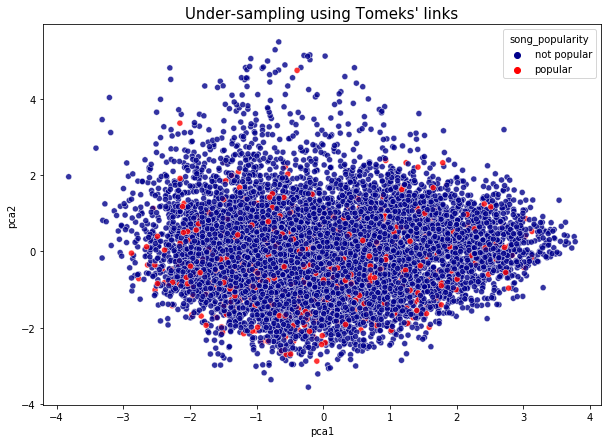

In [20]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

#### c.4) Oversampling - Random

In [21]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [22]:
X_over.shape, y_over.shape

((17358, 8), (17358,))

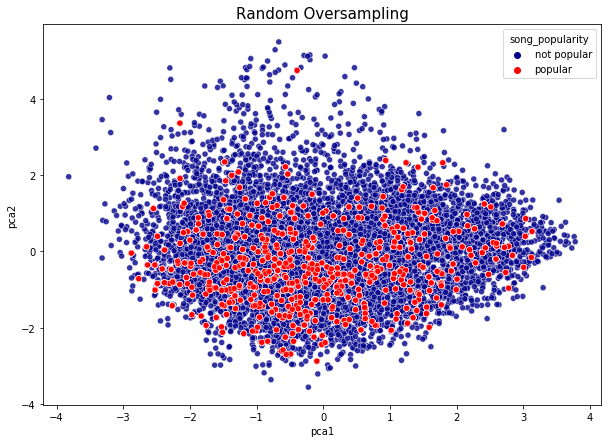

In [23]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### c.5) SMOTE

In [24]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((17358, 8), (17358,))

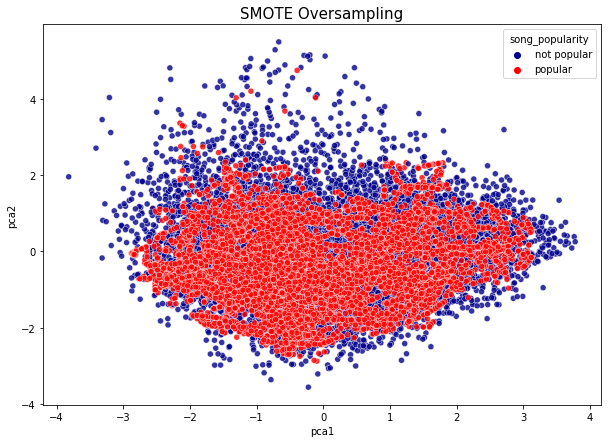

In [25]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

### K-means SMOTE

In [26]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=2, k_neighbors=3,cluster_balance_threshold=0)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)
y_ksmote.value_counts()

1    8680
0    8679
Name: song_popularity, dtype: int64

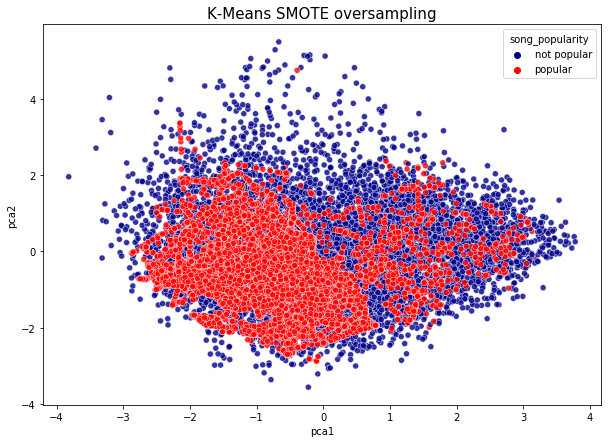

In [27]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [28]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

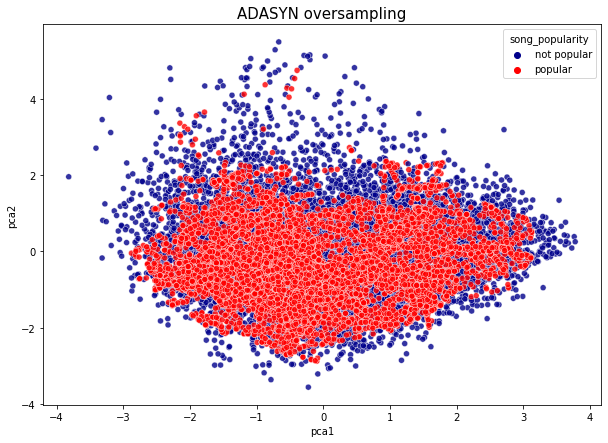

In [29]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

#### c.7) Class Weight

#### c.8) Ensamble (** not in the program)

_____________________________________________________________________________________________________________________

## d) Decision tree

### d.2) Unbalanced vs Balanced

In [30]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

roc_curves ={}
fpr_tpr = []


for bal_data,title in zip(data,titles):
    dt = DecisionTreeClassifier(criterion= 'entropy',max_depth=10, min_samples_leaf= 10, min_samples_split=20)
    dt.fit(bal_data[0],bal_data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))


    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.938055343995938
F1-score [0.96801259 0.024     ]

Recall [0.99247312 0.01369863]
Precision [0.94472876 0.09677419]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3720
           1       0.10      0.01      0.02       219

    accuracy                           0.94      3939
   macro avg       0.52      0.50      0.50      3939
weighted avg       0.90      0.94      0.92      3939

*** undersampling classification ***
Accuracy 0.5993907083015994
F1-score [0.7390873  0.13770492]

Recall [0.60080645 0.57534247]
Precision [0.96005155 0.07821229]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      3720
           1       0.08      0.58      0.14       219

    accuracy                           0.60      3939
   macro avg       0.52      0.59      0.44      3939
weighted avg       0.91      0.60      0.71      3939

*** condensed NN class

In [31]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20, min_samples_split=10, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)
print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))


*** cost-matrix classification ***
Accuracy 0.5123127697385124
F1-score [0.66006017 0.13740458]

              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3720
           1       0.08      0.70      0.14       219

    accuracy                           0.51      3939
   macro avg       0.52      0.60      0.40      3939
weighted avg       0.92      0.51      0.63      3939



### d.3) Compare results

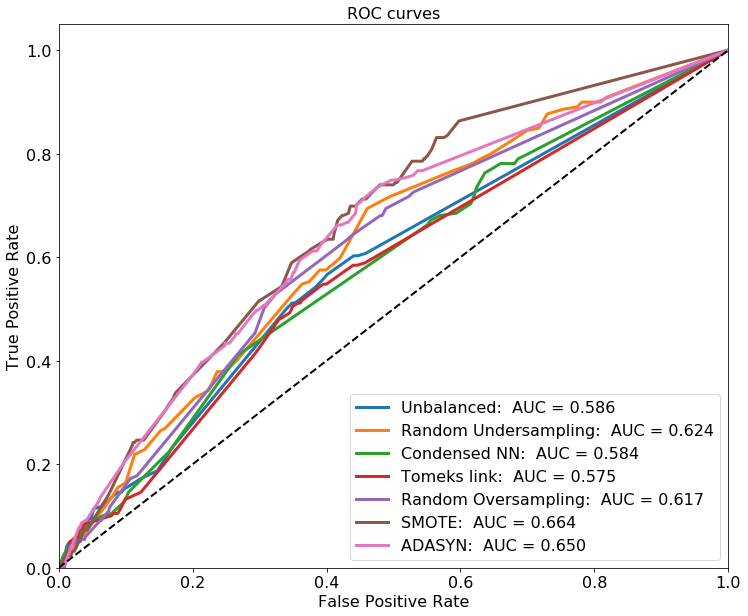

In [32]:
# plot roc curves
plt.figure(figsize=(12,10))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=3, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=3, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=3, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=3, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=3, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=3, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=16, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## d) KNN

### Unbalanced vs Balanced

In [33]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

roc_curves_knn ={}
fpr_tpr_knn = []

for bal_data,title in zip(data,titles):
    knn = KNeighborsClassifier(n_neighbors = 2,metric='euclidean', weights='distance')
    knn.fit(bal_data[0],bal_data[1])
    y_pred = knn.predict(X_test)

    # computes roc curve for each classifier
    y_score = knn.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc_knn = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves_knn[title] = roc_auc_knn
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr_knn.append((fpr,tpr))

    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9058136582889058
F1-score [0.9501679  0.14318707]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3720
           1       0.14      0.14      0.14       219

    accuracy                           0.91      3939
   macro avg       0.55      0.55      0.55      3939
weighted avg       0.90      0.91      0.91      3939

*** undersampling classification ***
Accuracy 0.5671490225945671
F1-score [0.71067368 0.14105793]

              precision    recall  f1-score   support

           0       0.96      0.56      0.71      3720
           1       0.08      0.64      0.14       219

    accuracy                           0.57      3939
   macro avg       0.52      0.60      0.43      3939
weighted avg       0.91      0.57      0.68      3939

*** condensed NN classification ***
Accuracy 0.8403148007108403
F1-score [0.91199105 0.13953488]

              precision    recall  f1-score   support

The condensed NearestNeighbor is the balancing technique yeilding the best results.<br>
The f1 score for class 0 goes from 0.24 to 0.38. This is due to the fact that **recall** improved as well, going from
0.15 in the unbalanced case (the classifier was not able to detect class 0) to 0.32 with the CNN. <br>
The precision decreses of few percent points (from 0.58 to 0.46) which is still acceptable considering the high recall.<br>
In terms of **recall**, **ADASYN** and **Random Undersampling** yeilded the highest recall (0.71 and 0.72 respectively). However after this rebalancing, although the f1 score increased to approximately 0.30, the precision of the model for that class resulted to be very low (0.19 for both). This means that in order to predict class 0 the classifier started to assign label 0 to more samples including those for which the real target was class 1.

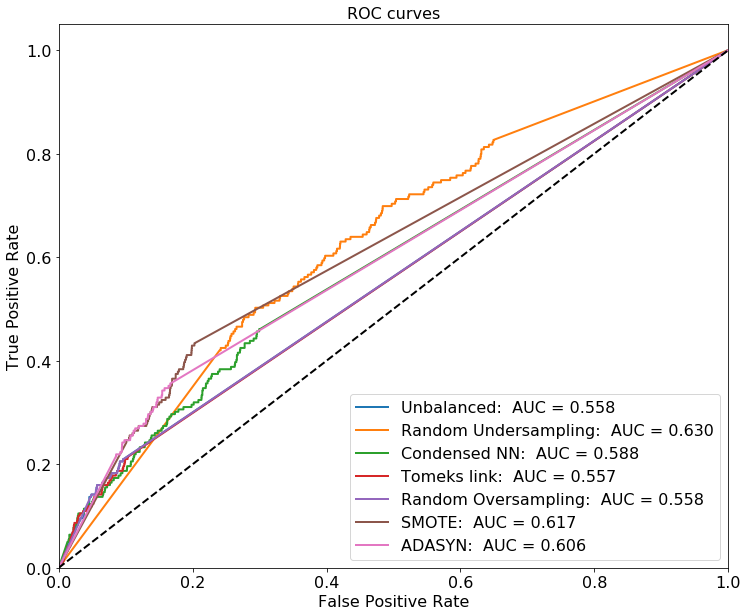

In [34]:
# plot roc curves
plt.figure(figsize=(12,10))

plt.plot(fpr_tpr_knn[0][0], fpr_tpr_knn[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves_knn['unbalanced'])
plt.plot(fpr_tpr_knn[1][0], fpr_tpr_knn[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves_knn['undersampling'])
plt.plot(fpr_tpr_knn[2][0], fpr_tpr_knn[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves_knn['condensed NN'])
plt.plot(fpr_tpr_knn[3][0], fpr_tpr_knn[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves_knn['Tomek links'])
plt.plot(fpr_tpr_knn[4][0], fpr_tpr_knn[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves_knn['oversampling'])
plt.plot(fpr_tpr_knn[5][0], fpr_tpr_knn[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves_knn['SMOTE'])
plt.plot(fpr_tpr_knn[6][0], fpr_tpr_knn[6][1], lw=2, label='ADASYN:  AUC = %.3f' % roc_curves_knn['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=16, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()